# The KLT Tracker
*By Erik Gärtner*


### 1.2.2 Inverse-additive scheme

The inverse-additive shceme is the following:
\begin{align}
E(u, v) &= \sum_{x,y} [J(x, y) - I(x - u, y -v)] ^2 \\
         &= \sum_{x,y} [D(x, y)] ^2
\end{align}

Which is derived into the form of $Zd = e$, where $Z$ is the Hessian matrix.

\begin{align}
\sum_{x,y} 
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2 \\
\end{bmatrix} 
\begin{bmatrix}
u \\
v
\end{bmatrix} = - \sum_{x,y}
\begin{bmatrix}
I_x D \\
I_y D
\end{bmatrix}
\end{align}

where D is $D(x,y) = J(x,y) - I(x - u,y -v)$

### Helper functions

In [21]:
import numpy as np
from  scipy import ndimage, interpolate

import matplotlib.pyplot as plt
from PIL import Image

In [23]:
def load_img(path, gray=True):
    rgb = plt.imread(path)
    rgb = np.array(rgb, dtype=np.float32) # Alternative:  rgb = Image.open(path)
    
    if gray:
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    else:
        return rgb

def show_img(img):
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [24]:
I = load_img('./images/chase0.png')
J = load_img('./images/chase1.png')

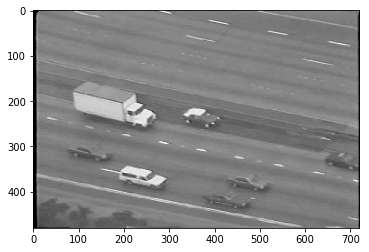

In [25]:
show_img(I)

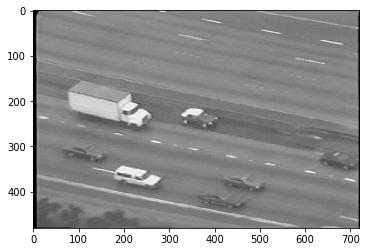

In [26]:
show_img(J)


### 1.3.1 Gradient Function

In [40]:
# Sobel filter
#X_FILTER = np.array([[1.0, 0.0, -1.0], [2., 0., -2.], [1.0, 0.0, -1.0]])

# Sharr filter
X_FILTER = np.array([[3.0, 0.0, -3.0], [10.0, 0.0, 10.0], [3.0, 0.0, -3.0]])
Y_FILTER = X_FILTER.T

def differentiate(img_arr):
    x_diff = ndimage.convolve(img_arr, X_FILTER) # multi dimensional convolusion (X_FILTER)
    y_diff = ndimage.convolve(img_arr, Y_FILTER) # multi dimensional convolusion (Y_FILTER)    
    return (x_diff, y_diff)

### 1.3.2 Estimating Z

Z is the Hessian matrix.

$$
Z(x,y) = 
\begin{bmatrix}
\frac{{\partial}^{2} f(x,y)}{\partial x^2} & \frac{{\partial}^{2} f(x,y)}{\partial x \partial y} \\
\frac{{\partial}^{2} f(x,y)}{\partial x \partial y} & \frac{{\partial}^{2} f(x,y)}{\partial y^2} \\
\end{bmatrix}
$$

In [5]:
def estimate_Z(x_diff, y_diff):
    x_diff = x_diff.flatten()
    y_diff = y_diff.flatten()
    
    grads_T = np.array([x_diff, y_diff])
    Z = np.dot(grads_T, grads_T.T)
    return Z

### 1.3.3 Difference Function

In [6]:
def estimate_e(I, J, Ix, Iy):   
    D = (J - I).flatten()
    Ix = Ix.flatten()
    Iy = Iy.flatten()
    
    grads_T = np.array([Ix, Iy])
    return -1 * np.dot(grads_T, D)

### 1.3.4 Interpolation Function

In [7]:
def interpolate_region(img_array):
    """
    Creates an bilinear interpolation of the image area sent in.
    Evaluate using spline(x, y)
    """
    x_arr = np.arange(0, img_array.shape[1])
    y_arr = np.arange(0, img_array.shape[0])
    interp = interpolate.interp2d(x_arr, y_arr, img_array, kind='linear') # Interpolate over a 2-D grid
    return interp

### 1.3.5 Finalizing the KLT Tracker

In [8]:
def calc_d(I, J, x, y, win_size, max_iter, min_disp):
    
    it = 0
    d_tot = np.array([0., 0.]).T
    
    # The window to evaluate
    win_x = np.arange(x, x + win_size[0], dtype=float)
    win_y = np.arange(y, y + win_size[1], dtype=float)
    
    template = I[x:x + win_size[0], y: y + win_size[1]]
    
    # Find image gradient in I
    Ix, Iy = differentiate(template)
    
    Z = estimate_Z(Ix, Iy)
    print(Z)
    Zinv = np.linalg.inv(Z)
    
    # Create interpolated versions the new frame
    J_inter = interpolate_region(J)  
    
    while it < max_iter:
        it += 1
        
        # Get the current window
        J_win = J_inter(win_x + d_tot[0], win_y + d_tot[1])

        e = estimate_e(template, J_win, Ix, Iy)       
        d = np.dot(Zinv, e)
        
        d_tot = d_tot + d
        
        if np.hypot(d[0], d[1]) <= min_disp:
            # Check if converged
            return d_tot
        
    return d_tot   

In [9]:
def calc_klt(old_image, new_image, input_points, win_size=(21, 21), max_iter=30, min_disp=0.01):
    
    output_points = []
    for (x, y) in input_points:
        d = calc_d(old_image, new_image, x, y, win_size, max_iter, min_disp)
        output_points.append((x + d[0], y + d[1]))
    return output_points

### 1.3.6 Test Implementation with OpenCV

In [10]:
import cv2

def opencv_klt(old_image, new_image, input_points, win_size=(21, 21)):
    pts = np.array(input_points ,np.float32)
    I2 = old_image.astype(np.uint8)
    J2 = new_image.astype(np.uint8)
    res = cv2.calcOpticalFlowPyrLK(I2, J2, pts, None, winSize=win_size, maxLevel=0) #prevPts[, nextPts[, status[, err[, winSize[, maxLevel[, criteria[, flags[, minEigThreshold]]]]]]]])
    return res[0]

### Experimentations

In [27]:
def load_img_uint8(path='./view0.png', gray=True):
    rgb = Image.open(path)
    rgb = np.array(rgb, dtype=np.uint8)
    if gray:
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    else:
        return rgb

array([[161.16109, 192.9719 ]], dtype=float32)

In [31]:
I_8 = load_img_uint8('./images/view0.png')
J_8 = load_img_uint8('./images/view1.png')

In [38]:
opencv_klt(I_8, J_8, [(157, 187)], (21, 21))

array([[161.16109, 192.9719 ]], dtype=float32)

In [39]:
calc_klt(I_8, J_8, [(157, 187), (150, 10)], (21, 21), max_iter=100)

[[4.13244411e+09 4.13208860e+09]
 [4.13208860e+09 4.16465005e+09]]
[[4.03887881e+09 3.99206299e+09]
 [3.99206299e+09 3.97320217e+09]]


[(158.9916023904749, 184.93536560296488),
 (151.39321119480937, 9.026694024392764)]